Minimal example of RelaxedBernoulliStraightThrough used in 1D Gaussian Mixture model, with custom guide based on AutoHierarchicalNormalMessenger.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoGuideList, AutoHierarchicalNormalMessenger
from pyro.infer.autoguide.utils import deep_getattr, deep_setattr
from pyro.nn.module import PyroParam
from torch.distributions import biject_to, constraints
from pyro.infer import SVI, Trace_ELBO, infer_discrete
from pyro.infer import Predictive
from pyro.poutine import block
from tqdm.auto import tqdm

Add mean to RelaxedBernoulliStraightThrough to make it useable with Messenger guides:

In [2]:
from pyro.distributions import RelaxedBernoulliStraightThrough
RelaxedBernoulliStraightThrough.mean = property(lambda self: self.probs)

Produce some data from two Normal distributions with different means:

In [3]:
def generate_data(n_components = 2, n_observations = 100, ps = 0.9):
    
    mus = torch.tensor((4., 4.))
    b = pyro.sample('b', dist.Bernoulli(probs = ps).expand([n_observations]).to_event(1))
                             
    mean = mus[0] + mus[1]*b
    
    data = pyro.sample("data_target", dist.Normal(loc = mean, scale = 1.))
    
    return data, b

Samples are discrete during sampling:

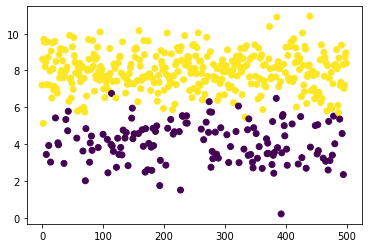

In [4]:
n_components = 2
n_observations = 500
ps = 0.75
data, b = generate_data(n_components, n_observations, ps)
plt.scatter(range(len(data)), data, c = b)

Our model using the Bernoulli distribution to assign observations to components:

In [5]:
def model(data, n_components, n_observations, i):
    
    ps = pyro.sample('ps', dist.Dirichlet(torch.ones(n_components)/10.))
    mus = pyro.sample('mus', dist.Gamma(20,2).expand([n_components]).to_event(1))
    b = pyro.sample('b', dist.Bernoulli(probs = ps[0]).expand([n_observations]).to_event(1))                    
    
    mean = mus[0] + mus[1]*b
    
    pyro.sample("data_target", dist.Normal(loc = mean, scale = torch.tensor(1.)).to_event(1), obs = data)

Define custom guide:

In [6]:
class MyGuideMessenger(AutoHierarchicalNormalMessenger):
    def get_posterior(self, name, prior):
        if isinstance(getattr(prior, "base_dist", None), dist.Bernoulli):
            try:
                probs = deep_getattr(self.locs, name)
            except AttributeError:
                # Initialize.
                with torch.no_grad():
                    init_probs = prior.mean.clone().detach()

                deep_setattr(self, "locs." + name, PyroParam(
                    init_probs, 
                    constraint=dist.constraints.unit_interval,
                    event_dim=prior.event_dim, 
                ))
                probs = deep_getattr(self.locs, name)
            
            return  dist.RelaxedBernoulliStraightThrough(
                probs=probs, temperature=torch.tensor(1.0)
            ).to_event(prior.event_dim)
        else:    
            return super().get_posterior(name, prior)

guide = MyGuideMessenger(model)

Training:

  0%|          | 0/20000 [00:00<?, ?it/s]

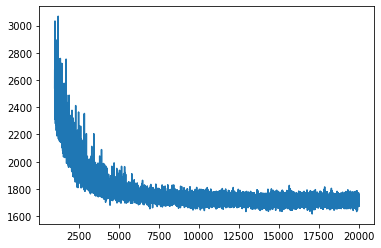

In [7]:
# Train model:
n_iterations = 20000
optim = pyro.optim.Adam({'lr': 0.001})
elbo = Trace_ELBO()
svi = SVI(model, guide, optim, loss=elbo)
elbos = []
for i in tqdm(range(n_iterations)):
    loss = svi.step(data, n_components, n_observations, i)
    elbos.append(loss)

posterior = Predictive(model, guide=guide, num_samples=1)(data, n_components, n_observations, i)

plt.plot(np.arange(1000, n_iterations, 1), elbos[1000:]);

Evaluate model:

In [8]:
print('Percentage correctly classified (should be close to 0.75): ', np.array(torch.sum(b - posterior['b'] == 0)/len(b)))
b = torch.abs(b - 1)
print('Percentage correctly classified after switching categories: ', np.array(torch.sum(b - posterior['b'] == 0)/len(b)))
print('Percentage classified in category 1: ', np.array(torch.sum(b == 1)/len(b)))

Percentage correctly classified (should be close to 0.75):  0.714
Percentage correctly classified after switching categories:  0.286
Percentage classified in category 1:  0.276
